In [2]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from pandas import Timestamp
from functools import partial
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
import sys
sys.path.append('..')
from src.helpers import get_data, clean_data, split_data, train_model, save_model, predict
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_set = get_data('../data/raw/train_set.csv')
train_set.head()

,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,2019-12-02 08:00:00+03:00,USEmbassy,74.088667,83.767111,0.000000,0.000000,0.962917,21.475000,0.299255,32.592686,1199,4374,21,14,6834,130,95.0
1,2020-03-17 02:00:00+03:00,USEmbassy,88.350233,96.003023,86.993256,107.929767,0.967667,19.233333,0.299255,32.592686,1199,4374,21,14,6834,130,139.0
2,2019-10-13 05:00:00+03:00,USEmbassy,47.540513,58.672308,48.684103,60.505128,0.999250,18.916667,0.299255,32.592686,1199,4374,21,14,6834,130,46.0
3,2020-04-04 11:00:00+03:00,USEmbassy,24.567619,27.151429,23.406667,27.316429,0.783500,25.475000,0.299255,32.592686,1199,4374,21,14,6834,130,33.0
4,2020-03-22 20:00:00+03:00,USEmbassy,46.644857,57.555143,46.195143,60.075714,0.721833,22.916667,0.299255,32.592686,1199,4374,21,14,6834,130,60.0


In [4]:
train_set = clean_data(train_set)
train_set.head()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_270m,population,ref_pm2_5,hour_of_day
0,74.088667,83.767111,74.088667,83.767111,0.962917,21.475000,0.299255,32.592686,1199,4374,14,6834,95.0,8
1,88.350233,96.003023,86.993256,107.929767,0.967667,19.233333,0.299255,32.592686,1199,4374,14,6834,139.0,2
2,47.540513,58.672308,48.684103,60.505128,0.999250,18.916667,0.299255,32.592686,1199,4374,14,6834,46.0,5
3,24.567619,27.151429,23.406667,27.316429,0.783500,25.475000,0.299255,32.592686,1199,4374,14,6834,33.0,11
4,46.644857,57.555143,46.195143,60.075714,0.721833,22.916667,0.299255,32.592686,1199,4374,14,6834,60.0,20


In [5]:
X = train_set.drop(columns = ['ref_pm2_5'], axis=1)
y = train_set['ref_pm2_5']

In [6]:
Xtrain, Xtest, ytrain, ytest = split_data(X, y)

In [7]:
rfr = RandomForestRegressor()

In [8]:
train_model(rfr, Xtrain, ytrain)

In [9]:
save_model(rfr, '../models/rfr_default.joblib')

In [10]:
rmse, ypred = predict(rfr, Xtest, ytest)
rmse

13.37

#### Hyperopt

In [11]:
space = {
    'n_estimators':scope.int(hp.quniform('n_estimators', 100, 500, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 30, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 20, 1)),
    'min_samples_split':scope.int(hp.quniform('min_samples_split', 1, 100, 1)),
    'max_features': hp.choice('max_features', ['log2', 'sqrt', 'auto']),
    'oob_score': hp.choice('oob_score', [True, False])
    
}

In [12]:
def optimize(params):
    model = RandomForestRegressor(**params)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    rmse = mean_squared_error(ytest, ypred, squared=False)
    return -1*rmse

In [13]:
optimization_function = partial(optimize)

In [14]:
trials = Trials()

In [15]:
best = fmin(
    fn=optimization_function,
    space=space,
    algo=tpe.suggest,
    max_evals=15,
    trials=trials)

100%|███████████████████████████████████████████████| 15/15 [02:12<00:00,  8.86s/trial, best loss: -19.249210280000263]


In [16]:
best

{'max_depth': 2.0,
 'max_features': 2,
 'min_samples_leaf': 19.0,
 'min_samples_split': 51.0,
 'n_estimators': 189.0,
 'oob_score': 0}

In [17]:
rfr = RandomForestRegressor(max_depth= 2,
                            max_features= 'auto',
                            min_samples_leaf= 19,
                            min_samples_split= 51,
                            n_estimators= 189,
                            oob_score= True)


In [18]:
train_model(rfr, Xtrain, ytrain)

In [19]:
save_model(rfr, '../models/rfr_hyperopt.joblib')

In [20]:
rmse, ypred = predict(rfr, Xtest, ytest)
rmse

19.23

#### Randomized Search

In [21]:
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 500],
    'max_depth': [1, 5, 8, 15, 25, 30],
    'max_features': ['log2', 'sqrt', 'auto'],
    'min_samples_leaf': [1, 2, 4, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 50, 100],
    'oob_score':[True, False]
}

In [22]:
rf = RandomForestRegressor()

In [23]:
model = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    cv=5,
    n_iter=100
)

In [25]:
train_model(model, Xtrain, ytrain)
print(f'Best score: {model.best_score_}')
print('Best parameters set:')
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best score: -15.306664107564671
Best parameters set:
	max_depth: 30
	max_features: auto
	min_samples_leaf: 2
	min_samples_split: 10
	n_estimators: 150
	oob_score: False


In [30]:
rf = RandomForestRegressor(
    max_depth=30,
    max_features='auto',
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=150,
    oob_score=False)

In [31]:
train_model(rf, Xtrain, ytrain)

In [32]:
save_model(rf, '../models/rfr_randomized.joblib')

In [34]:
rmse, ypred = predict(rf, Xtest, ytest)
rmse

13.09

#### GridSearchCV

In [35]:
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300, 350],
    'max_depth': [10, 15, 20, 25, 30],
    'max_features': ['sqrt', 'auto'],
    'min_samples_leaf': [2, 4, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 50],
    'oob_score':[True, False]
}

In [36]:
rf = RandomForestRegressor()

In [37]:
model = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    cv=5,
)

In [38]:
train_model(model, Xtrain, ytrain)
print(f'Best score: {model.best_score_}')
print('Best parameters set:')
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits
Best score: -15.275261802966591
Best parameters set:
	max_depth: 15
	max_features: auto
	min_samples_leaf: 2
	min_samples_split: 2
	n_estimators: 150
	oob_score: True


In [40]:
rf = RandomForestRegressor(
    max_depth=15,
    max_features='auto',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=150,
    oob_score=True)

In [41]:
train_model(rf, Xtrain, ytrain)

In [42]:
save_model(rf, '../models/rfr_grid_search.joblib')

In [43]:
rmse, ypred = predict(rf, Xtest, ytest)
rmse

13.2

#### Testing on held-out data

In [45]:
Xactual = get_data('../data/raw/test_set.csv')
Xactual = clean_data(Xactual)
Xactual.head()

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_270m,population,hour_of_day
0,9.903636,10.259545,8.852727,10.097727,0.748000,26.491667,0.299255,32.592686,1199,4374,14,6834,12
1,38.428333,45.940714,40.087143,48.159762,0.995000,18.225000,0.299255,32.592686,1199,4374,14,6834,6
2,13.278000,14.967333,13.278000,14.967333,0.687500,24.891667,0.299255,32.592686,1199,4374,14,6834,17
3,36.304000,40.366750,89.182500,93.572500,0.868417,22.616667,0.299255,32.592686,1199,4374,14,6834,9
4,56.686410,67.412308,55.048974,66.089487,0.782083,23.350000,0.299255,32.592686,1199,4374,14,6834,19


In [46]:
yactual = get_data('../data/raw/test_solution.csv')
yactual.head()

,ref_pm2_5
0,30.0
1,44.0
2,27.0
3,48.0
4,57.0


In [47]:
rmse, ypred = predict(rf, Xactual, yactual)
rmse

13.1

In [48]:
yactual.shape, ypred.shape

((2733, 1), (2733,))

In [49]:
ypred= ypred.reshape(2733, 1)
ypred.shape

(2733, 1)

Text(0, 0.5, 'Predictions ')

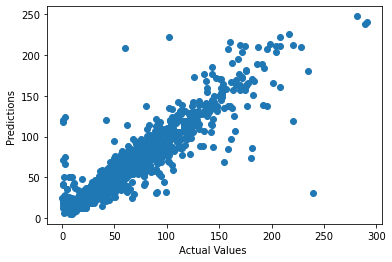

In [50]:
g=plt.scatter(yactual, ypred)
g.axes.set_xlabel('Actual Values ')
g.axes.set_ylabel('Predictions ')